In [38]:
import pandas as pd
import re
from nltk.corpus import stopwords
import pickle
import numpy as np
from string import punctuation
import time
from ast import literal_eval
from collections import Counter
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
import statsmodels.formula.api as sm

In [2]:
df=pd.read_csv('/home/ec2-user/SageMaker/New Uncertainty/Sentiment Analysis/LMuncertainty.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502909 entries, 0 to 502908
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   ID                502909 non-null  int64 
 1   UncertaintyCount  502909 non-null  int64 
 2   UncertaintyWords  502909 non-null  object
dtypes: int64(2), object(1)
memory usage: 11.5+ MB
None


In [3]:
print(df.head())

          ID  UncertaintyCount       UncertaintyWords
0  294326637                 0                     []
1  294308147                 0                     []
2  294323196                 1              ['could']
3  294262284                 2  ['possible', 'could']
4  294234319                 0                     []


## 1. LM uncertainty term occurences

In [ ]:
# All unique LM uncertainty terms and occurences
allMatchWords=[]
for list in df['UncertaintyWords']:
    allMatchWords=allMatchWords+literal_eval(list)
print(len(allMatchWords))

In [ ]:
allMatchWordsCount=Counter(allMatchWords)

In [66]:
print(len(allMatchWordsCount))
print(allMatchWordsCount)

195
Counter({'could': 132997, 'may': 90508, 'risk': 51580, 'believe': 27361, 'nearly': 20595, 'possible': 19773, 'appear': 18473, 'suggest': 16791, 'seem': 13285, 'almost': 12244, 'probably': 9613, 'pende': 8274, 'sometimes': 6797, 'risky': 6675, 'perhaps': 6122, 'uncertainty': 6055, 'predict': 5977, 'depend': 5770, 'roughly': 5764, 'revise': 5395, 'possibility': 5393, 'exposure': 5350, 'assume': 4907, 'doubt': 4852, 'unusual': 4787, 'unclear': 4363, 'preliminary': 3760, 'possibly': 3696, 'tend': 3631, 'anticipate': 3588, 'apparently': 3441, 'hide': 3143, 'vary': 2816, 'speculation': 2326, 'apparent': 2188, 'confusion': 2148, 'volatility': 2105, 'uncertain': 2040, 'somewhat': 1906, 'differ': 1897, 'maybe': 1849, 'volatile': 1812, 'reconsider': 1684, 'cautious': 1666, 'assumption': 1637, 'speculative': 1603, 'sudden': 1577, 'suddenly': 1445, 'vague': 1434, 'dependent': 1349, 'approximately': 1349, 'likelihood': 1345, 'unexpected': 1344, 'unusually': 1275, 'variable': 1237, 'speculate': 

In [65]:
for term in allMatchWordsCount.keys():
    doc=nlp(term)
    for token in doc:
        print(token, token.pos_, token.tag_)

could VERB MD
possible ADJ JJ
exposure NOUN NN
revise NOUN NN
pende PROPN NNP
appear VERB VB
seem VERB VB
confusion NOUN NN
confusing ADJ JJ
may VERB MD
perhaps ADV RB
possibly ADV RB
believe VERB VB
doubt NOUN NN
almost ADV RB
risk NOUN NN
suggest VERB VBP
speculation NOUN NN
unusually ADV RB
confuse PROPN NNP
variation NOUN NN
vary VERB VBP
nearly ADV RB
unsettled ADJ JJ
predict VERB VB
apparent ADJ JJ
reassess PROPN NNP
sometimes ADV RB
dependent ADJ JJ
unidentified ADJ JJ
unusual ADJ JJ
apparently ADV RB
approximately ADV RB
possibility NOUN NN
tentative ADJ JJ
speculate PROPN NNP
maybe ADV RB
fluctuation NOUN NN
roughly ADV RB
probably ADV RB
reconsider NOUN NN
unfamiliarity NOUN NN
probable ADJ JJ
conceivable ADJ JJ
anticipate PROPN NNP
unclear ADJ JJ
clarification NOUN NN
assume PROPN NNP
somewhat ADV RB
unfamiliar ADJ JJ
varied ADJ JJ
unexpected ADJ JJ
tend VERB VB
depend VERB VB
conditional ADJ JJ
uncertainty NOUN NN
tentatively ADV RB
sometime ADV RB
sudden ADJ JJ
reinterpret

## 2. Remove certain terms

In [ ]:
term_removed=['could','may','maybe','might']

In [ ]:
df=df.reset_index(drop=True)

In [ ]:
# Remove certain terms from all matched noun chunks
df['UncertaintyWordsFiltered']=None
df['UncertaintyCountFiltered']=0
for i in range(0,len(df)):
    list=literal_eval(df['UncertaintyWords'][i])
    list_new=[w for w in list if w not in term_removed]
    df['UncertaintyWordsFiltered'][i]=list_new
    df['UncertaintyCountFiltered'][i]=len(df['UncertaintyWordsFiltered'][i])
print(df.info())

In [18]:
print(df.head(10))

          ID  UncertaintyCount       UncertaintyWords  \
0  294326637                 0                     []   
1  294308147                 0                     []   
2  294323196                 1              ['could']   
3  294262284                 2  ['possible', 'could']   
4  294234319                 0                     []   
5  294323101                 1           ['exposure']   
6  294205735                 1             ['revise']   
7  294261564                 0                     []   
8  294337453                 1              ['pende']   
9  294281403                 2     ['appear', 'seem']   

  UncertaintyWordsFiltered  UncertaintyCountFiltered  
0                       []                         0  
1                       []                         0  
2                       []                         0  
3               [possible]                         1  
4                       []                         0  
5               [exposure]                

## 3. Calculate uncertainty scores

In [19]:
# All news metadata
allNews=pd.read_pickle('/home/ec2-user/SageMaker/New Uncertainty/parsed_xml.pkl')
print(allNews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822737 entries, 0 to 822736
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             822737 non-null  object        
 1   Title          822737 non-null  object        
 2   Type           822737 non-null  object        
 3   StartDate      822737 non-null  datetime64[ns]
 4   EndDate        822737 non-null  object        
 5   Text           822737 non-null  object        
 6   TextWordCount  822737 non-null  object        
 7   PubTitle       822737 non-null  object        
 8   SourceType     822737 non-null  object        
 9   Year           822737 non-null  int64         
 10  Month          822737 non-null  int64         
 11  Newspaper      822737 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 75.3+ MB
None


In [20]:
# Reg relevant articles
df_regSentsExpand=pd.read_pickle('/home/ec2-user/SageMaker/New Uncertainty/Reg Relevance/RegSentsExpand_NounChunks3.pkl')
print(df_regSentsExpand.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822737 entries, 0 to 822736
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   ID                           822737 non-null  object
 1   RegSentsExpand               822737 non-null  object
 2   NounChunksMatch              822737 non-null  int64 
 3   NounChunkMatchWords          822737 non-null  object
 4   NounChunkMatchWordsFiltered  822737 non-null  object
 5   NounChunkMatchFiltered       822737 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 37.7+ MB
None


In [21]:
# Merge with metadata
df_regSentsExpand=df_regSentsExpand.merge(allNews[['ID','Title','StartDate','Text','Newspaper','Year','Month','Type','SourceType']],
                           on='ID',how='left')
print(df_regSentsExpand.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822737 entries, 0 to 822736
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ID                           822737 non-null  object        
 1   RegSentsExpand               822737 non-null  object        
 2   NounChunksMatch              822737 non-null  int64         
 3   NounChunkMatchWords          822737 non-null  object        
 4   NounChunkMatchWordsFiltered  822737 non-null  object        
 5   NounChunkMatchFiltered       822737 non-null  int64         
 6   Title                        822737 non-null  object        
 7   StartDate                    822737 non-null  datetime64[ns]
 8   Text                         822737 non-null  object        
 9   Newspaper                    822737 non-null  object        
 10  Year                         822737 non-null  int64         
 11  Month                     

In [22]:
# Remove duplicated articles
IDs_nodup=pd.read_csv('/home/ec2-user/SageMaker/New Uncertainty/IDs_no_duplicates.csv')
print(IDs_nodup.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788516 entries, 0 to 788515
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   ID      788516 non-null  int64
dtypes: int64(1)
memory usage: 6.0 MB
None


In [23]:
IDs_nodup['ID']=IDs_nodup['ID'].astype('str')
df_reg=IDs_nodup.merge(df_regSentsExpand,on='ID',how='left').reset_index(drop=True)
print(df_reg.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788516 entries, 0 to 788515
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ID                           788516 non-null  object        
 1   RegSentsExpand               788516 non-null  object        
 2   NounChunksMatch              788516 non-null  int64         
 3   NounChunkMatchWords          788516 non-null  object        
 4   NounChunkMatchWordsFiltered  788516 non-null  object        
 5   NounChunkMatchFiltered       788516 non-null  int64         
 6   Title                        788516 non-null  object        
 7   StartDate                    788516 non-null  datetime64[ns]
 8   Text                         788516 non-null  object        
 9   Newspaper                    788516 non-null  object        
 10  Year                         788516 non-null  int64         
 11  Month                     

In [30]:
# Use filtered noun chunk matches to define reg relevance
df_reg.loc[df_reg['NounChunkMatchFiltered']!=0,'RegRelevance']=1
print("# of reg relevant articles:",df_reg[df_reg['RegRelevance']==1]['ID'].nunique())

# of reg relevant articles: 493418


In [28]:
# Total word count
GIsentiments=pd.read_csv('/home/ec2-user/SageMaker/New Uncertainty/Sentiment Analysis/GIsentiments.csv')
GIsentiments['ID']=GIsentiments['ID'].astype('str')
print(GIsentiments.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502909 entries, 0 to 502908
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              502909 non-null  object
 1   TotalWordCount  502909 non-null  int64 
 2   GIposCount      502909 non-null  int64 
 3   GInegCount      502909 non-null  int64 
 4   GIposWords      502909 non-null  object
 5   GInegWords      502909 non-null  object
dtypes: int64(3), object(3)
memory usage: 23.0+ MB
None


In [29]:
# Merge
df['ID']=df['ID'].astype('str')
df=df.merge(GIsentiments[['ID','TotalWordCount']],on='ID',how='left')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788516 entries, 0 to 788515
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ID                           788516 non-null  object        
 1   RegSentsExpand               788516 non-null  object        
 2   NounChunksMatch              788516 non-null  int64         
 3   NounChunkMatchWords          788516 non-null  object        
 4   NounChunkMatchWordsFiltered  788516 non-null  object        
 5   NounChunkMatchFiltered       788516 non-null  int64         
 6   Title                        788516 non-null  object        
 7   StartDate                    788516 non-null  datetime64[ns]
 8   Text                         788516 non-null  object        
 9   Newspaper                    788516 non-null  object        
 10  Year                         788516 non-null  int64         
 11  Month                     

In [26]:
df=df_reg.merge(df,on='ID',how='left')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788516 entries, 0 to 788515
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ID                           788516 non-null  object        
 1   RegSentsExpand               788516 non-null  object        
 2   NounChunksMatch              788516 non-null  int64         
 3   NounChunkMatchWords          788516 non-null  object        
 4   NounChunkMatchWordsFiltered  788516 non-null  object        
 5   NounChunkMatchFiltered       788516 non-null  int64         
 6   Title                        788516 non-null  object        
 7   StartDate                    788516 non-null  datetime64[ns]
 8   Text                         788516 non-null  object        
 9   Newspaper                    788516 non-null  object        
 10  Year                         788516 non-null  int64         
 11  Month                     

In [31]:
df=df[df['RegRelevance']==1].reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493418 entries, 0 to 493417
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ID                           493418 non-null  object        
 1   RegSentsExpand               493418 non-null  object        
 2   NounChunksMatch              493418 non-null  int64         
 3   NounChunkMatchWords          493418 non-null  object        
 4   NounChunkMatchWordsFiltered  493418 non-null  object        
 5   NounChunkMatchFiltered       493418 non-null  int64         
 6   Title                        493418 non-null  object        
 7   StartDate                    493418 non-null  datetime64[ns]
 8   Text                         493418 non-null  object        
 9   Newspaper                    493418 non-null  object        
 10  Year                         493418 non-null  int64         
 11  Month                     

In [32]:
df['UncertaintyScore']=df['UncertaintyCountFiltered']/df['TotalWordCount']*100
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493418 entries, 0 to 493417
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ID                           493418 non-null  object        
 1   RegSentsExpand               493418 non-null  object        
 2   NounChunksMatch              493418 non-null  int64         
 3   NounChunkMatchWords          493418 non-null  object        
 4   NounChunkMatchWordsFiltered  493418 non-null  object        
 5   NounChunkMatchFiltered       493418 non-null  int64         
 6   Title                        493418 non-null  object        
 7   StartDate                    493418 non-null  datetime64[ns]
 8   Text                         493418 non-null  object        
 9   Newspaper                    493418 non-null  object        
 10  Year                         493418 non-null  int64         
 11  Month                     

## 4. Construct uncertainty index

In [33]:
# Change data format
df['StartDate']=df['StartDate'].astype('datetime64[ns]')
df['Year']=df['StartDate'].dt.year
df['Month']=df['StartDate'].dt.month
df['Newspaper']=df['Newspaper'].astype('category')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493418 entries, 0 to 493417
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ID                           493418 non-null  object        
 1   RegSentsExpand               493418 non-null  object        
 2   NounChunksMatch              493418 non-null  int64         
 3   NounChunkMatchWords          493418 non-null  object        
 4   NounChunkMatchWordsFiltered  493418 non-null  object        
 5   NounChunkMatchFiltered       493418 non-null  int64         
 6   Title                        493418 non-null  object        
 7   StartDate                    493418 non-null  datetime64[ns]
 8   Text                         493418 non-null  object        
 9   Newspaper                    493418 non-null  category      
 10  Year                         493418 non-null  int64         
 11  Month                     

In [34]:
# Unique year-month dataframe
df_ym=df[['Year','Month']].drop_duplicates().sort_values(['Year','Month']).reset_index(drop=True).reset_index()
df_ym['YM']=df_ym['index']+1
df_ym=df_ym.drop('index',axis=1)
print(df_ym)

     Year  Month   YM
0    1985      1    1
1    1985      2    2
2    1985      3    3
3    1985      4    4
4    1985      5    5
..    ...    ...  ...
423  2020      4  424
424  2020      5  425
425  2020      6  426
426  2020      7  427
427  2020      8  428

[428 rows x 3 columns]


In [35]:
df=df.merge(df_ym[['Year','Month','YM']],on=['Year','Month'],how='left').sort_values(['Year','Month']).reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493418 entries, 0 to 493417
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ID                           493418 non-null  object        
 1   RegSentsExpand               493418 non-null  object        
 2   NounChunksMatch              493418 non-null  int64         
 3   NounChunkMatchWords          493418 non-null  object        
 4   NounChunkMatchWordsFiltered  493418 non-null  object        
 5   NounChunkMatchFiltered       493418 non-null  int64         
 6   Title                        493418 non-null  object        
 7   StartDate                    493418 non-null  datetime64[ns]
 8   Text                         493418 non-null  object        
 9   Newspaper                    493418 non-null  category      
 10  Year                         493418 non-null  int64         
 11  Month                     

In [36]:
# Function to estimate index (suppressing constant)
def estimate_index(var_name):
    FE_OLS=sm.ols(formula=var_name + ' ~ 0+C(YM)+C(Newspaper)',
        data=df).fit()
    print(FE_OLS.summary())

    FE_estimates=pd.DataFrame()
    FE_estimates[var_name+'Index']=FE_OLS.params[0:len(df_ym)]
    FE_estimates=FE_estimates.reset_index().rename(columns={'index':'FE'})
    FE_estimates['YM']=FE_estimates['FE'].str.split("[",expand=True)[1].str.split("]",expand=True)[0].astype('int64')
    
    return FE_estimates

In [39]:
# Uncertainty index
UncertaintyIndex=estimate_index('UncertaintyScore')

                            OLS Regression Results                            
Dep. Variable:       UncertaintyScore   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.213
Date:                Fri, 04 Jun 2021   Prob (F-statistic):          4.28e-243
Time:                        16:35:35   Log-Likelihood:            -5.4022e+05
No. Observations:              493418   AIC:                         1.081e+06
Df Residuals:                  492984   BIC:                         1.086e+06
Df Model:                         433                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

In [40]:
print(UncertaintyIndex.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FE                     428 non-null    object 
 1   UncertaintyScoreIndex  428 non-null    float64
 2   YM                     428 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 10.2+ KB
None


In [41]:
UncertaintyIndex=df_ym.merge(UncertaintyIndex,on='YM',how='outer').\
        sort_values(['Year','Month'])
print(UncertaintyIndex.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 0 to 427
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   428 non-null    int64  
 1   Month                  428 non-null    int64  
 2   YM                     428 non-null    int64  
 3   FE                     428 non-null    object 
 4   UncertaintyScoreIndex  428 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 20.1+ KB
None


In [42]:
UncertaintyIndex=UncertaintyIndex.rename(columns={'UncertaintyScoreIndex':'UncertaintyIndex'})
print(UncertaintyIndex.head())

   Year  Month  YM        FE  UncertaintyIndex
0  1985      1   1  C(YM)[1]          0.388407
1  1985      2   2  C(YM)[2]          0.369037
2  1985      3   3  C(YM)[3]          0.389335
3  1985      4   4  C(YM)[4]          0.398572
4  1985      5   5  C(YM)[5]          0.399877


In [43]:
# Export
UncertaintyIndex.to_csv('/home/ec2-user/SageMaker/New Uncertainty/Sentiment Analysis/RegRelevant_MonthlyUncertaintyIndex_Robust.csv',index=False)

## Compare with baseline uncertainty index

In [44]:
UncertaintyIndex_baseline=pd.read_csv('/home/ec2-user/SageMaker/New Uncertainty/Sentiment Analysis/RegRelevant_MonthlySentimentIndex.csv')
print(UncertaintyIndex_baseline.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              428 non-null    int64  
 1   Month             428 non-null    int64  
 2   YM                428 non-null    int64  
 3   UncertaintyIndex  428 non-null    float64
 4   LMindex           428 non-null    float64
 5   GIindex           428 non-null    float64
 6   LSDindex          428 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 23.5 KB
None


In [48]:
import scipy.stats
import matplotlib.pyplot as plt

In [46]:
print('Baseline & Robust:',scipy.stats.pearsonr(UncertaintyIndex['UncertaintyIndex'], UncertaintyIndex_baseline['UncertaintyIndex']))

Baseline & Robust: (0.8874366289024693, 2.2231402436195317e-145)


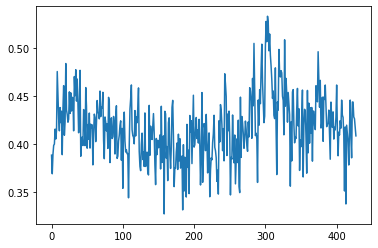

In [51]:
y=UncertaintyIndex['UncertaintyIndex']
plt.plot(y)
plt.show()